In [4]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

from joblib import load



Let's focus on one area for simpler understanding. We select only the columns relative to area 4

In [ ]:
df = pd.read_csv('consumption_and_temperatures.csv')


#Select the area that you want to study
area = 1
test_set_days = 10

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing(df, area = area, test_set_days = test_set_days)

## Model Definition

In [7]:
class Feed_Forward(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feed_Forward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
input_size = X_train.shape[1]
hidden_size = 50 
model = Feed_Forward(input_size, hidden_size)

criterion = nn.MSELoss()  #Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Model training

Epoch [10/150], Training Loss: 0.7709, Validation Loss: 0.6543
Epoch [20/150], Training Loss: 0.4883, Validation Loss: 0.3863
Epoch [30/150], Training Loss: 0.2404, Validation Loss: 0.1654
Epoch [40/150], Training Loss: 0.1202, Validation Loss: 0.0880
Epoch [50/150], Training Loss: 0.0994, Validation Loss: 0.0909
Epoch [60/150], Training Loss: 0.0760, Validation Loss: 0.0628
Epoch [70/150], Training Loss: 0.0662, Validation Loss: 0.0542
Epoch [80/150], Training Loss: 0.0586, Validation Loss: 0.0503
Epoch [90/150], Training Loss: 0.0538, Validation Loss: 0.0463
Epoch [100/150], Training Loss: 0.0502, Validation Loss: 0.0457
Epoch [110/150], Training Loss: 0.0475, Validation Loss: 0.0435
Epoch [120/150], Training Loss: 0.0454, Validation Loss: 0.0432
Epoch [130/150], Training Loss: 0.0437, Validation Loss: 0.0427
Epoch [140/150], Training Loss: 0.0423, Validation Loss: 0.0426
Epoch [150/150], Training Loss: 0.0412, Validation Loss: 0.0427


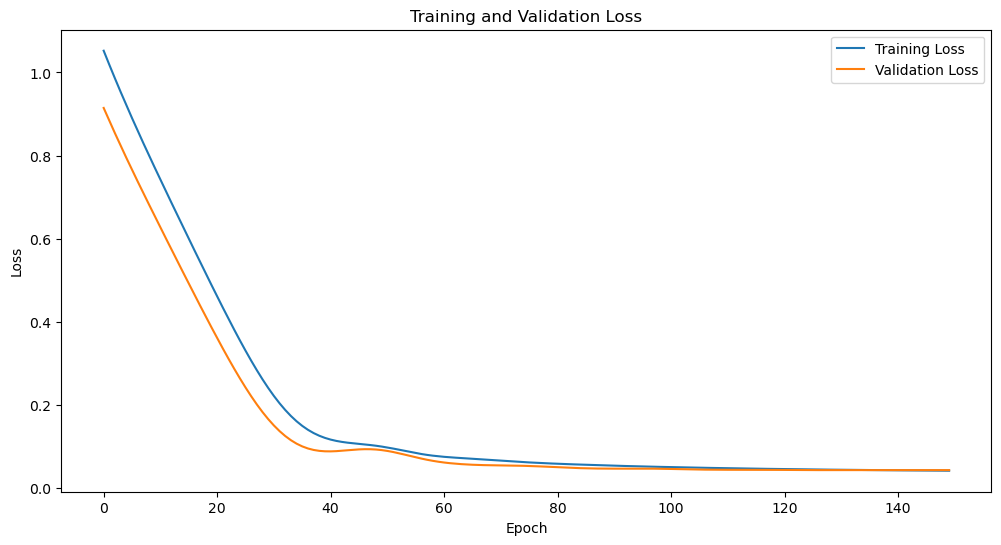

In [9]:
num_epochs = 150  # Ajuste ce nombre selon tes besoins
train_loss_values = []  # Liste pour enregistrer les valeurs de la perte d'entraînement
val_loss_values = []  # Liste pour enregistrer les valeurs de la perte de validation

for epoch in range(num_epochs):
    model.train()  # Mettre le modèle en mode d'entraînement
    inputs = torch.FloatTensor(X_train.values)
    targets = torch.FloatTensor(y_train.values).view(-1, 1)
    
    # Forward pass et calcul de la perte pour le set d'entraînement
    outputs = model(inputs)
    train_loss = criterion(outputs, targets)
    train_loss_values.append(train_loss.item())
    
    # Backward and optimize
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Évaluation et calcul de la perte pour le set de validation
    model.eval()  # Mettre le modèle en mode d'évaluation
    with torch.no_grad():
        val_inputs = torch.FloatTensor(X_val.values)
        val_targets = torch.FloatTensor(y_val.values).view(-1, 1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        val_loss_values.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:  # Afficher les pertes toutes les 10 époques
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Tracer les graphiques des pertes d'entraînement et de validation
plt.figure(figsize=[12,6])
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
model.eval()  # Mettre le modèle en mode d'évaluation
with torch.no_grad():
    inputs = torch.FloatTensor(X_test.values)
    targets = torch.FloatTensor(y_test.values).view(-1, 1)
    outputs = model(inputs)
    mse_loss = criterion(outputs, targets)
    print(f'Test MSE Loss: {mse_loss.item():.4f}')
    rmse_loss = torch.sqrt(mse_loss)
    print(f'Test RMSE Loss: {rmse_loss.item():.4f}')


Test MSE Loss: 0.0435
Test RMSE Loss: 0.2086


## Back to Original Data Size 

before model evaluation

In [11]:
#Back to Dataframe format

extracted_features = [f'NO{area}_temperature', f'NO{area}_consumption_avg_prev_day', f'NO{area}_consumption_24h_before', 'month', 'day', 'hour'] # + f'NO{area}_consumption_1h_before'

# Convertir les tenseurs PyTorch en arrays NumPy
inputs_np = inputs.numpy()
outputs_np = outputs.view(-1).numpy()  # De même pour outputs

# Créer un DataFrame à partir des arrays NumPy
# Assumons que les colonnes de inputs correspondent aux 'features' utilisées pour le training
df_out = pd.DataFrame(inputs_np, columns=extracted_features)
df_out['Output'] = outputs_np

df_out = df_out.drop([f'NO{area}_temperature', f'NO{area}_consumption_avg_prev_day', f'NO{area}_consumption_24h_before'], axis=1) # +f'NO{area}_consumption_1h_before'
df_out.columns


Index(['month', 'day', 'hour', 'Output'], dtype='object')

In [12]:
#Get the scaler trained on the data to do the inverse trnsformation

scaler = load('scaler.joblib') 

features = ['NO1_consumption', 'NO1_temperature', 'NO2_consumption', 'NO2_temperature', 'NO3_consumption', 'NO3_temperature', 'NO4_consumption', 'NO4_temperature', 'NO5_consumption', 
            'NO5_temperature', 'month', 'day', 'hour', 'NO1_consumption_avg_prev_day', 'NO2_consumption_avg_prev_day', 'NO3_consumption_avg_prev_day', 'NO4_consumption_avg_prev_day', 'NO5_consumption_avg_prev_day']

# Crée un dictionnaire vide
features_stats = {}

# Remplir le dictionnaire avec les noms de features comme clés et des tuples (moyenne, écart type) comme valeurs
for i, feature in enumerate(features):
    features_stats[feature] = (scaler.mean_[i], scaler.scale_[i])

# Afficher le dictionnaire
print(features_stats)

{'NO1_consumption': (3981.0436009012637, 1322.5456843142601), 'NO1_temperature': (7.764708900814608, 8.247860610260771), 'NO2_consumption': (4169.7763540568085, 722.3703449646478), 'NO2_temperature': (8.695760193282162, 5.933965242221361), 'NO3_consumption': (3078.0098907762713, 479.62795876368966), 'NO3_temperature': (6.471469500331401, 7.793164353262397), 'NO4_consumption': (2158.026760123517, 358.95717035620817), 'NO4_temperature': (3.5041457313292423, 6.721843042860674), 'NO5_consumption': (1896.8621299586496, 307.15345928067035), 'NO5_temperature': (8.834070257210664, 6.102418963148515), 'month': (6.5221611682452805, 3.349962447655115), 'day': (15.735669538816788, 8.803396994727473), 'hour': (11.49898441341857, 6.921844135142303), 'NO1_consumption_avg_prev_day': (3981.477302283471, 1253.1522860429614), 'NO2_consumption_avg_prev_day': (4169.884235578063, 680.2662590450351), 'NO3_consumption_avg_prev_day': (3077.9182458301084, 452.676204918579), 'NO4_consumption_avg_prev_day': (2158

In [13]:
# Initialiser les listes pour les moyennes et écarts types personnalisés
custom_mean = []
custom_std = []

# Extraire les moyennes et écarts types pour les caractéristiques dans features_4
for feature in df_out.columns[:-1]:
    mean, std = features_stats[feature]
    custom_mean.append(mean)
    custom_std.append(std)

custom_mean.append(features_stats[f'NO{area}_consumption'][0])
custom_std.append(features_stats[f'NO{area}_consumption'][1])



print(custom_mean)
print(custom_std)
# Convertir en numpy arrays pour correspondre à ce que s'attend sklearn

custom_mean = np.array(custom_mean)
custom_std = np.array(custom_std)

# Instancier un nouveau StandardScaler
scaler_invert = StandardScaler()

# Définir manuellement les moyennes et écarts types pour ce nouveau scaler
scaler_invert.mean_ = custom_mean
scaler_invert.scale_ = custom_std

[6.5221611682452805, 15.735669538816788, 11.49898441341857, 3981.0436009012637]
[3.349962447655115, 8.803396994727473, 6.921844135142303, 1322.5456843142601]


In [14]:
# Offscale the dataframe :

data_final = scaler_invert.inverse_transform(df_out)

df_final = pd.DataFrame(data_final, columns=df_out.columns)


df_final['month'] = df_final['month'].astype(int)
df_final['day'] = df_final['day'].astype(int)
df_final['hour'] = df_final['hour'].astype(int)


df_final['month'] = df_final['month'].astype(str)
df_final['day'] = df_final['day'].astype(str)
df_final['hour'] = df_final['hour'].astype(str)


df_final['timestamp'] = pd.to_datetime('2023-' + df_final['month'] + '-' + df_final['day'] + ' ' + df_final['hour'] + ':00:00')

df_final['Target'] = df[f'NO{area}_consumption'].tail(24*test_set_days).values


df_final.head()

,month,day,hour,Output,timestamp,Target
0,12,22,0,4966.767090,2023-12-22 00:00:00,5042.637172
1,12,22,1,4961.866211,2023-12-22 01:00:00,4935.532332
2,12,22,2,5006.695312,2023-12-22 02:00:00,4868.119128
3,12,22,3,5055.626953,2023-12-22 03:00:00,4827.153964
4,12,22,4,5198.350586,2023-12-22 04:00:00,4921.860012


## Model Evaluation

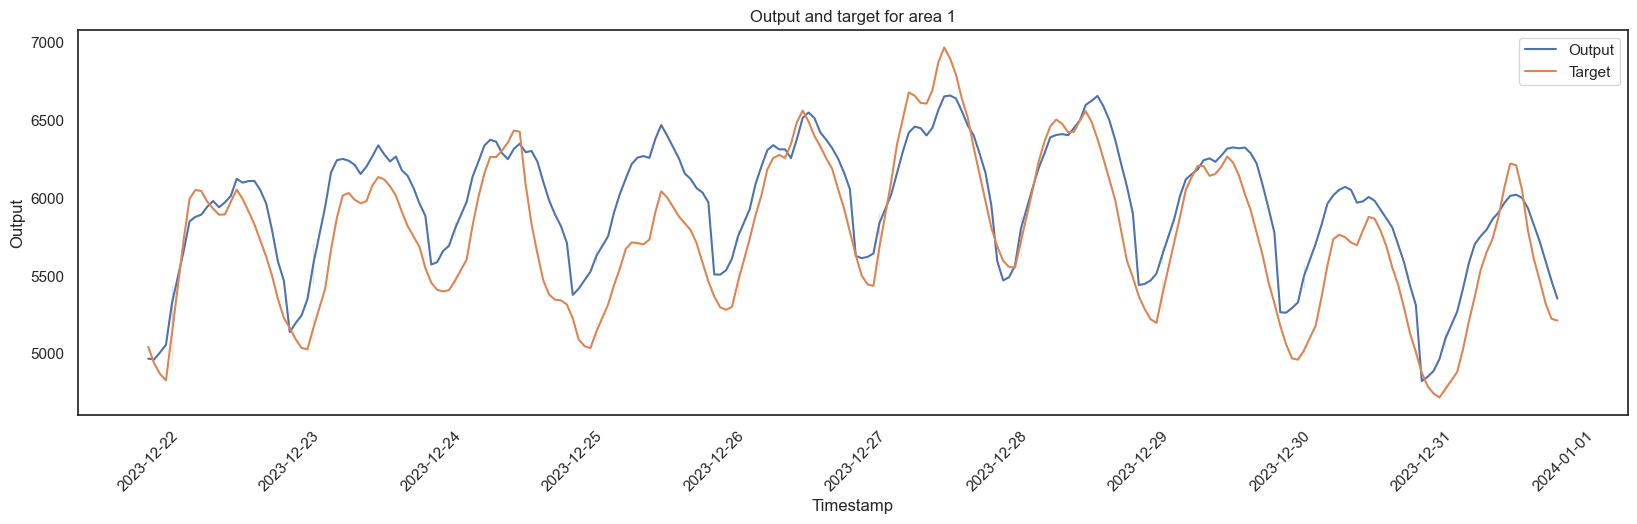

In [15]:
sns.set_theme(style="white") 
# Crée un graphique de taille plus grande pour une meilleure lisibilité
plt.figure(figsize=[20, 5])

# Dessine le graphique en utilisant Seaborn
# Note : sns.lineplot automatiquement ajoute une ligne de tendance
sns.lineplot(x='timestamp', y='Output', data=df_final, label='Output')
sns.lineplot(x='timestamp', y='Target', data=df_final, label='Target')

# Définis le titre et les étiquettes des axes
plt.title(f'Output and target for area {area}')
plt.xlabel('Timestamp')
plt.ylabel('Output')

# Tourne les étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Montre le graphique
plt.show()

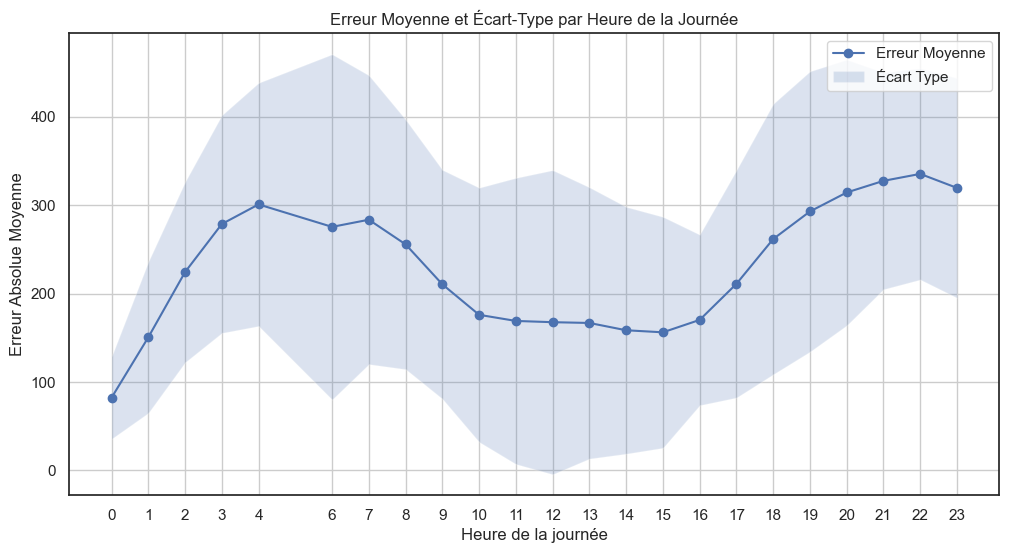

Global Mean Error for Feed Forward model = 5287.86932838125


In [16]:
df_final['abs_error'] = (df_final['Target'] - df_final['Output']).abs()
df_final['hour'] = df_final['timestamp'].dt.hour

grouped = df_final.groupby('hour')['abs_error'].agg(['mean', 'std'])

# Créer le plot
plt.figure(figsize=(12, 6))

# Heures de la journée
heures = grouped.index  # Les heures uniques dans le DataFrame

# Tracer l'erreur moyenne
plt.plot(heures, grouped['mean'], label='Erreur Moyenne', marker='o')

# Ajouter l'intervalle de l'écart-type autour de l'erreur moyenne
plt.fill_between(heures, grouped['mean'] - grouped['std'], grouped['mean'] + grouped['std'], alpha=0.2, label='Écart Type')

# Ajouter des titres et légendes
plt.title('Erreur Moyenne et Écart-Type par Heure de la Journée')
plt.xlabel('Heure de la journée')
plt.ylabel('Erreur Absolue Moyenne')
plt.xticks(heures)  # Assurez-vous que toutes les heures sont affichées
plt.legend()

# Afficher le plot
plt.grid(True)
plt.show()

print(f"Global Mean Error for Feed Forward model = {grouped['mean'].sum()}")

## Try with your own data : 

In [17]:
df = pd.read_csv('consumption_and_temperatures.csv')


#Select the area that you want to study
area = 1
test_set_days = 10

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing(df, area = area, test_set_days = test_set_days)

c:\Users\vadim\Google Drive\ECL\Mobilité\NTNU\Cours\SPRING\DL\Project 2\utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'NO{i}_consumption_avg_prev_day'][:24] = df[f'NO{i}_consumption_avg_prev_day'][24]
c:\Users\vadim\Google Drive\ECL\Mobilité\NTNU\Cours\SPRING\DL\Project 2\utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'NO{i}_consumption_avg_prev_day'][:24] = df[f'NO{i}_consumption_avg_prev_day'][24]
c:\Users\vadim\Google Drive\ECL\Mobilité\NTNU\Cours\SPRING\DL\Project 2\utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

In [18]:
model.eval()  # Mettre le modèle en mode d'évaluation
with torch.no_grad():
    inputs = torch.FloatTensor(X_test.values)
    targets = torch.FloatTensor(y_test.values).view(-1, 1)
    outputs = model(inputs)
    mse_loss = criterion(outputs, targets)
    print(f'Test MSE Loss: {mse_loss.item():.4f}')
    rmse_loss = torch.sqrt(mse_loss)
    print(f'Test RMSE Loss: {rmse_loss.item():.4f}')

Test MSE Loss: 0.0435
Test RMSE Loss: 0.2086


In [19]:
#Back to Dataframe format

extracted_features = [f'NO{area}_temperature', f'NO{area}_consumption_avg_prev_day', f'NO{area}_consumption_24h_before', 'month', 'day', 'hour'] # + f'NO{area}_consumption_1h_before'

# Convertir les tenseurs PyTorch en arrays NumPy
inputs_np = inputs.numpy()
outputs_np = outputs.view(-1).numpy()  # De même pour outputs

# Créer un DataFrame à partir des arrays NumPy
# Assumons que les colonnes de inputs correspondent aux 'features' utilisées pour le training
df_out = pd.DataFrame(inputs_np, columns=extracted_features)
df_out['Output'] = outputs_np

df_out = df_out.drop([f'NO{area}_temperature', f'NO{area}_consumption_avg_prev_day', f'NO{area}_consumption_24h_before'], axis=1) # +f'NO{area}_consumption_1h_before'
df_out.columns


Index(['month', 'day', 'hour', 'Output'], dtype='object')

In [20]:
#Get the scaler trained on the data to do the inverse trnsformation

scaler = load('scaler.joblib') 

features = ['NO1_consumption', 'NO1_temperature', 'NO2_consumption', 'NO2_temperature', 'NO3_consumption', 'NO3_temperature', 'NO4_consumption', 'NO4_temperature', 'NO5_consumption', 
            'NO5_temperature', 'month', 'day', 'hour', 'NO1_consumption_avg_prev_day', 'NO2_consumption_avg_prev_day', 'NO3_consumption_avg_prev_day', 'NO4_consumption_avg_prev_day', 'NO5_consumption_avg_prev_day']

# Crée un dictionnaire vide
features_stats = {}

# Remplir le dictionnaire avec les noms de features comme clés et des tuples (moyenne, écart type) comme valeurs
for i, feature in enumerate(features):
    features_stats[feature] = (scaler.mean_[i], scaler.scale_[i])

# Afficher le dictionnaire
print(features_stats)

{'NO1_consumption': (3981.0436009012637, 1322.5456843142601), 'NO1_temperature': (7.764708900814608, 8.247860610260771), 'NO2_consumption': (4169.7763540568085, 722.3703449646478), 'NO2_temperature': (8.695760193282162, 5.933965242221361), 'NO3_consumption': (3078.0098907762713, 479.62795876368966), 'NO3_temperature': (6.471469500331401, 7.793164353262397), 'NO4_consumption': (2158.026760123517, 358.95717035620817), 'NO4_temperature': (3.5041457313292423, 6.721843042860674), 'NO5_consumption': (1896.8621299586496, 307.15345928067035), 'NO5_temperature': (8.834070257210664, 6.102418963148515), 'month': (6.5221611682452805, 3.349962447655115), 'day': (15.735669538816788, 8.803396994727473), 'hour': (11.49898441341857, 6.921844135142303), 'NO1_consumption_avg_prev_day': (3981.477302283471, 1253.1522860429614), 'NO2_consumption_avg_prev_day': (4169.884235578063, 680.2662590450351), 'NO3_consumption_avg_prev_day': (3077.9182458301084, 452.676204918579), 'NO4_consumption_avg_prev_day': (2158

In [21]:
# Initialiser les listes pour les moyennes et écarts types personnalisés
custom_mean = []
custom_std = []

# Extraire les moyennes et écarts types pour les caractéristiques dans features_4
for feature in df_out.columns[:-1]:
    mean, std = features_stats[feature]
    custom_mean.append(mean)
    custom_std.append(std)

custom_mean.append(features_stats[f'NO{area}_consumption'][0])
custom_std.append(features_stats[f'NO{area}_consumption'][1])



print(custom_mean)
print(custom_std)
# Convertir en numpy arrays pour correspondre à ce que s'attend sklearn

custom_mean = np.array(custom_mean)
custom_std = np.array(custom_std)

# Instancier un nouveau StandardScaler
scaler_invert = StandardScaler()

# Définir manuellement les moyennes et écarts types pour ce nouveau scaler
scaler_invert.mean_ = custom_mean
scaler_invert.scale_ = custom_std

[6.5221611682452805, 15.735669538816788, 11.49898441341857, 3981.0436009012637]
[3.349962447655115, 8.803396994727473, 6.921844135142303, 1322.5456843142601]


In [22]:
# Offscale the dataframe :

data_final = scaler_invert.inverse_transform(df_out)

df_final = pd.DataFrame(data_final, columns=df_out.columns)


df_final['month'] = df_final['month'].astype(int)
df_final['day'] = df_final['day'].astype(int)
df_final['hour'] = df_final['hour'].astype(int)


df_final['month'] = df_final['month'].astype(str)
df_final['day'] = df_final['day'].astype(str)
df_final['hour'] = df_final['hour'].astype(str)


df_final['timestamp'] = pd.to_datetime('2023-' + df_final['month'] + '-' + df_final['day'] + ' ' + df_final['hour'] + ':00:00')

df_final['Target'] = df[f'NO{area}_consumption'].tail(24*test_set_days).values


df_final.head()

,month,day,hour,Output,timestamp,Target
0,12,22,0,4966.767090,2023-12-22 00:00:00,5042.637172
1,12,22,1,4961.866211,2023-12-22 01:00:00,4935.532332
2,12,22,2,5006.695312,2023-12-22 02:00:00,4868.119128
3,12,22,3,5055.626953,2023-12-22 03:00:00,4827.153964
4,12,22,4,5198.350586,2023-12-22 04:00:00,4921.860012


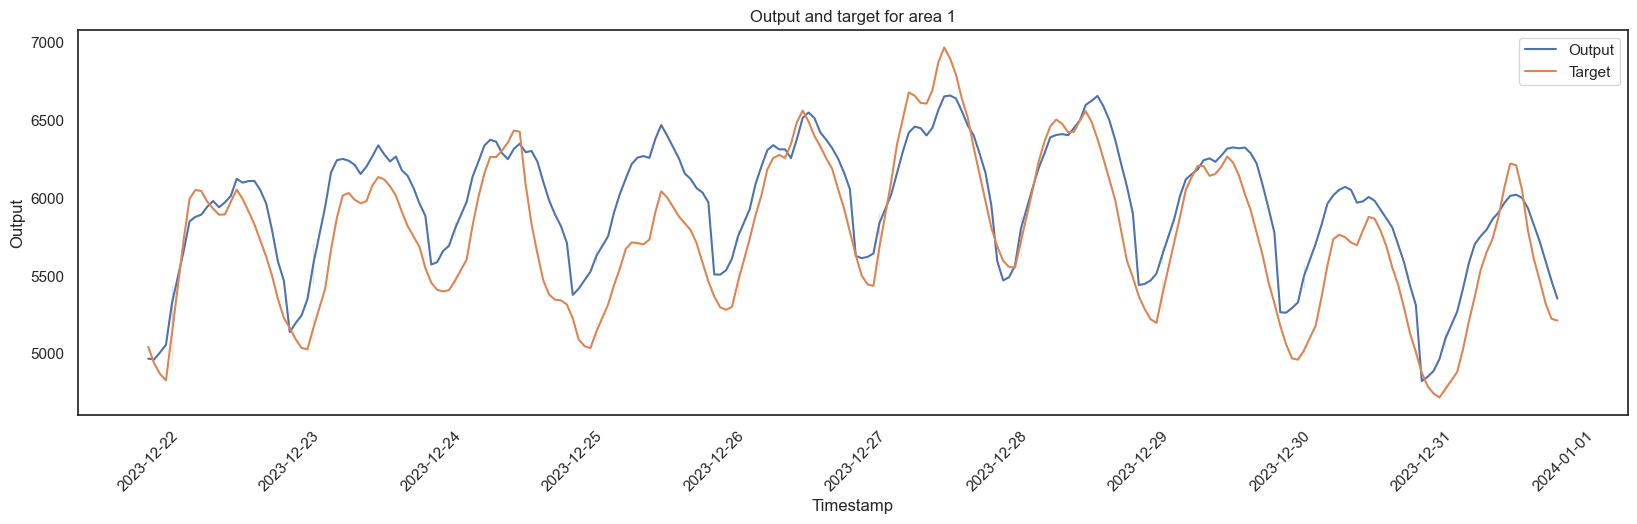

In [23]:
sns.set_theme(style="white") 
# Crée un graphique de taille plus grande pour une meilleure lisibilité
plt.figure(figsize=[20, 5])

# Dessine le graphique en utilisant Seaborn
# Note : sns.lineplot automatiquement ajoute une ligne de tendance
sns.lineplot(x='timestamp', y='Output', data=df_final, label='Output')
sns.lineplot(x='timestamp', y='Target', data=df_final, label='Target')

# Définis le titre et les étiquettes des axes
plt.title(f'Output and target for area {area}')
plt.xlabel('Timestamp')
plt.ylabel('Output')

# Tourne les étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Montre le graphique
plt.show()

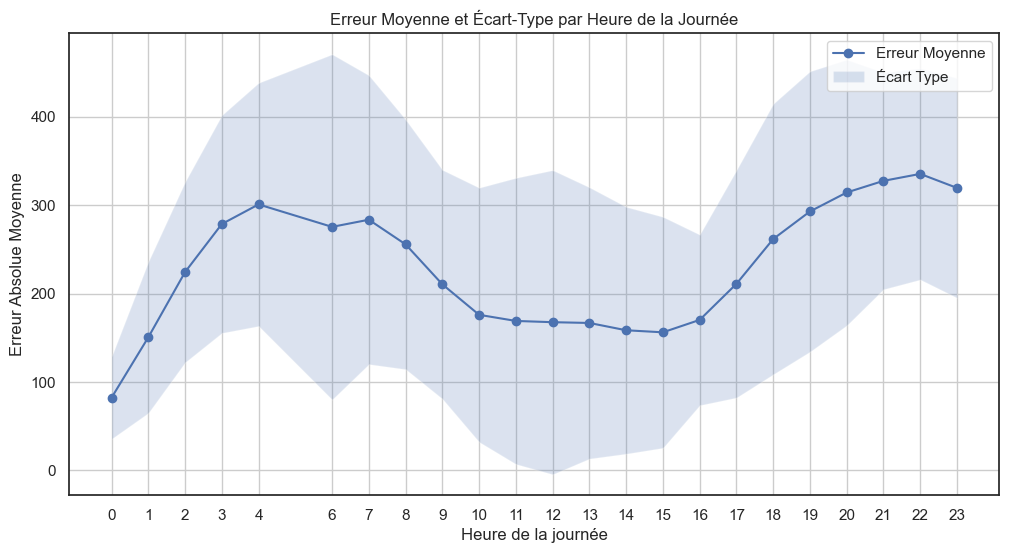

Global Mean Error for Feed Forward model = 5287.86932838125


In [24]:
df_final['abs_error'] = (df_final['Target'] - df_final['Output']).abs()
df_final['hour'] = df_final['timestamp'].dt.hour

grouped = df_final.groupby('hour')['abs_error'].agg(['mean', 'std'])

# Créer le plot
plt.figure(figsize=(12, 6))

# Heures de la journée
heures = grouped.index  # Les heures uniques dans le DataFrame

# Tracer l'erreur moyenne
plt.plot(heures, grouped['mean'], label='Erreur Moyenne', marker='o')

# Ajouter l'intervalle de l'écart-type autour de l'erreur moyenne
plt.fill_between(heures, grouped['mean'] - grouped['std'], grouped['mean'] + grouped['std'], alpha=0.2, label='Écart Type')

# Ajouter des titres et légendes
plt.title('Erreur Moyenne et Écart-Type par Heure de la Journée')
plt.xlabel('Heure de la journée')
plt.ylabel('Erreur Absolue Moyenne')
plt.xticks(heures)  # Assurez-vous que toutes les heures sont affichées
plt.legend()

# Afficher le plot
plt.grid(True)
plt.show()

print(f"Global Mean Error for Feed Forward model = {grouped['mean'].sum()}")